## 5.2　グリッドサーチ

In [1]:
import mglearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid, StratifiedKFold

グリッドサーチは、パラメータの全ての組み合わせを試して調整する方法である。

RBF（radial basis function）のSVMにおける、カーネルのバンド幅を表すgammaと正則化パラメータCについて<br>
6×6=36通りの組み合わせの表（**グリッド**）が作成でき、それを全て試してパラメータを調整していく。

### 5.2.1　単純なグリッドサーチ

In [2]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

print('Size of training set: {}  Size of test set{}'.format(X_train.shape[0], X_test.shape[0]))

Size of training set: 112  Size of test set38


In [3]:
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_test, y_test)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
        
print('Best score: {:.2f}'.format(best_score))
print('Best parameters: {}'.format(best_parameters))

Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


### 5.2.2　パラメータ過剰適合の危険性と検証セット

データを以下のように3分割する。

・訓練セット：モデル適合<br>
・検証セット：パラメータ選択<br>
・テストセット：評価

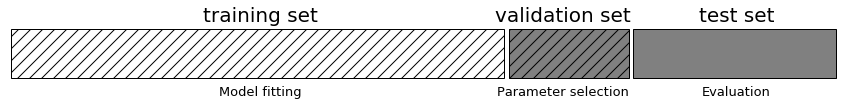

In [4]:
mglearn.plots.plot_threefold_split()

まず学習セット（trainval）とテストセット（test）に分ける。<br>
その後、学習データ(trainval）を訓練セット（train）と検証セット（valid）に分割する。

つまり学習セットの中で、**モデル構築用**のデータと**score評価用**のデータの2つを用意しただけである。

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print('Size of training set: {}  \nSize of validation set: {}  \nSize of test set:{}'
      .format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Size of training set: 84  
Size of validation set: 28  
Size of test set:38


In [6]:
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print('Best score on validation set: {:.2f}'.format(best_score))
print('Best parameters', best_parameters)
print('Test set score with best parameters: {:.2f}'.format(test_score))

Best score on validation set: 0.96
Best parameters {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


上記のような、**訓練セット・検証セット・テストセット**の分割は、パラメータ調整をした上でのモデリングの基本となる。

### 5.2.3　交差検証を用いたグリッドサーチ

訓練セットと検証セットの分割は、1度だけ行うのではなく、それぞれのパラメータの組み合わせごとに交差検証して行うのが良い。

処理の順序としては、パラメータの組み合わせを1つ選択し、それに対して5分割交差検証を行う。<br>
その後、5分割交差検証における5つのスコアに対して平均を取り、best_scoreより大きければ、そのパラメータを採用する。<br>
これを全てのパラメータの組み合わせ（36通り）に対して実行していく。

In [7]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        score = np.mean(scores)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print('Best score on validation set: {:.2f}'.format(best_score))
print('Best parameters', best_parameters)
print('Test set score with best parameters: {:.2f}'.format(test_score))

Best score on validation set: 0.97
Best parameters {'C': 10, 'gamma': 0.1}
Test set score with best parameters: 0.97


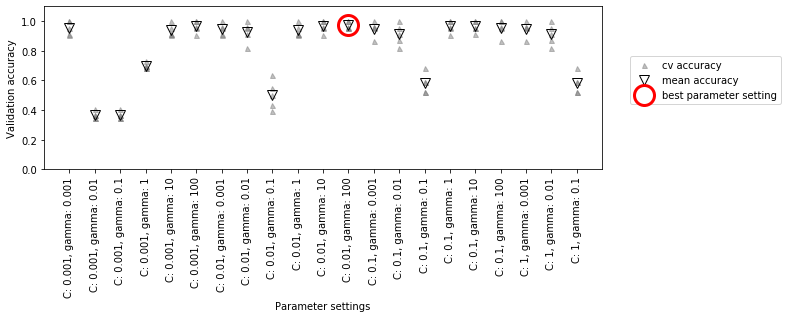

In [8]:
mglearn.plots.plot_cross_val_selection()

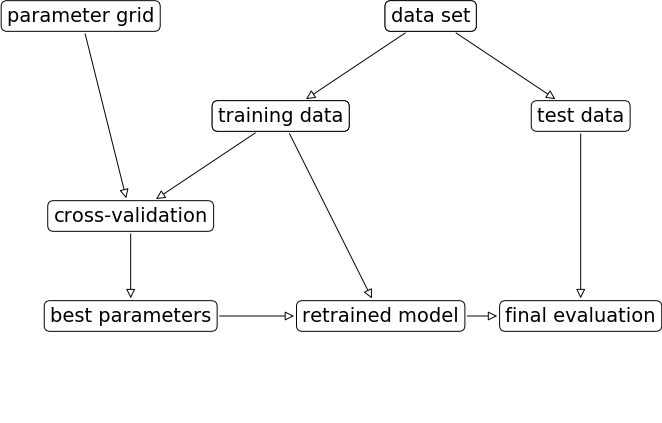

In [9]:
mglearn.plots.plot_grid_search_overview()

交差検証によるグリッドサーチは、GridSearchCVクラスとしてscikit-learnに実装されている。

In [10]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

print('Parameter grid:\n{}'.format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


X_trainとy_trainに対して交差検証を行い、訓練セット（X_tr, y_tr）と検証セット（X_val, y_val）を用いてモデルを作成する。<br>
その後、テストセット（X_test, y_test）で汎化性能を評価する。

GridSearchCVは、fitメソッドで交差検証とグリッドサーチを組み合わせて、最良のパラメータを選定してくれる。

In [11]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross validation score: {:.2f}'.format(grid_search.best_score_))
print('Test set score: {:.2f}'.format(grid_search.score(X_test, y_test)))

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross validation score: 0.97
Test set score: 0.97


以下の2つについて比較しておく。

・grid_search.best_score_：訓練データ（X_train, y_train／X_tr, y_tr, X_val, y_val）での交差検証における平均のベストスコア<br>
・grid_search.score：訓練データ（X_train, y_train／X_tr, y_tr, X_val, y_val）で作成したモデルをテストセット（X_test, y_test）で評価したスコア

汎化性能は、grid_search.scoreの値である。

In [12]:
print('Best estimator: {}'.format(grid_search.best_estimator_))

Best estimator: SVC(C=10, gamma=0.1)


#### 5.2.3.1　交差検証の結果の解析

グリッドサーチにおける交差検証の結果は、cv_results_属性に格納されている。

In [13]:
results = pd.DataFrame(grid_search.cv_results_)

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004793,0.003246,0.001397,0.000492,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.001998,0.001095,0.000800,0.000400,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.001599,0.000490,0.001000,0.000633,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.001999,0.000632,0.000600,0.000490,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.003002,0.001674,0.001594,0.001015,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


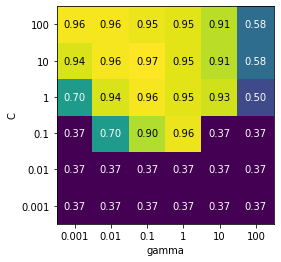

In [14]:
scores = np.array(results.mean_test_score).reshape(6, 6)

mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap='viridis')

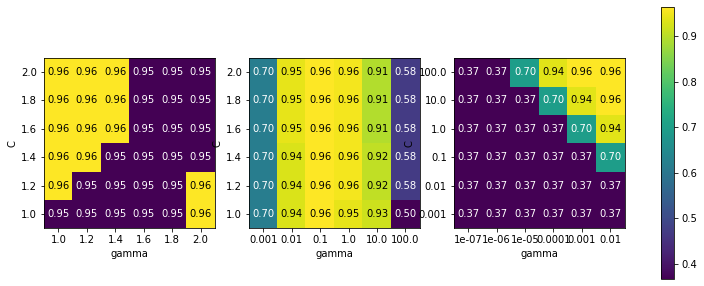

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6), 'gamma': np.linspace(1, 2, 6)}
param_grid_one_log = {'C': np.linspace(1, 2, 6), 'gamma': np.logspace(-3, 2, 6)}
param_grid_range = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)
    
    scores_image = mglearn.tools.heatmap(scores, xlabel='gamma', ylabel='C',
                                        xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap='viridis', ax=ax)
    
plt.colorbar(scores_image, ax=axes.tolist())

#### 5.2.3.2　グリッドでないサーチ空間

グリッドサーチでは、条件付き（場合分け）のパラメータ探索も行うことができる。

In [16]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              
              {'kernel': ['linear'],
               'C': [0.001, 0.1, 1, 10, 100]}]

print('List of grids:\n{}'.format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.1, 1, 10, 100]}]


In [17]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation score: {:.2f}'.format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [18]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
mean_fit_time,0.0027976,0.00259776,0.00179868,0.00199862,0.0019999,0.00179887,0.000999212,0.00139928,0.00120049,0.00119953,...,0.000999498,0.000999498,0.00139952,0.00179939,0.0021986,0.00119925,0.00139909,0.000999308,0.000999212,0.00119882
std_fit_time,0.000397805,0.000489067,0.000399018,2.33602e-07,1.77394e-06,0.000399828,6.91003e-07,0.000489687,0.000400044,0.000399092,...,2.78041e-07,4.10191e-07,0.000489591,0.000399971,0.000399756,0.000399828,0.000489551,4.15697e-07,3.01578e-07,0.000400282
mean_score_time,0.00360007,0.000999498,0.000399685,0.00019989,0.000398922,0.000799561,0.000999498,0.000999069,0.000998926,0.000998974,...,0.00039959,0.000399542,0.000399828,0.000599337,0.000799751,0.000599098,0.000599575,0.000799417,0.000599909,0.000599623
std_score_time,0.00372437,0.000632863,0.000489513,0.00039978,0.000488579,0.00039978,7.74769e-07,0.000631505,1.78416e-07,9.04735e-07,...,0.000489395,0.000489337,0.000489687,0.000489356,0.000399876,0.000489163,0.000489551,0.000399709,0.000489824,0.00048959
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,100,0.001,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.01,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,1,0.956522,0.869565,0.521739,0.347826,1,1,1,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.913043,0.956522,0.956522,0.913043,0.521739,0.347826,0.913043,0.956522,1,0.956522


#### 5.2.3.3　異なる交差検証手法を用いたグリッドサーチ

データが非常に大きい場合や、モデルの計算に非常に時間がかかる場合には<br>
ShuffleSplit、もしくはStatifiedShuffleSplitを用いて、n_iter=1とすると良い。

#### 5.2.3.4　ネストした交差検証

訓練セット・検証セット・テストデータに分けてモデルを作成した後に、より正確なモデルの評価を行うことができる。<br>
ネストした交差検証では、訓練データとテストデータの分割・訓練セットと検証セットの分割の両方に交差検証を用いて評価を行う。

In [19]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)

print('Cross-validation scores: ', scores)
print('Mean cross-validation score: ', scores.mean())

Cross-validation scores:  [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score:  0.9666666666666668


上記で行っている処理を、コードで細かく表現してみる。

In [20]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    
    # 訓練データとテストデータに分割
    for training_samples, test_samples in outer_cv.split(X, y):
        best_params = {}
        best_score = 0
        
        for parameters in parameter_grid:
            cv_scores = []
            
            # 学習セットと検証セットに分割
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            
            # 1つのパラメータの組み合わせに対する5分割交差検証のmean_score
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = parameters
                
            # for parameters ... に戻る
        
        # best_paramsを用いて訓練データでモデルを作成、テストデータでスコアを出す
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
        
    return np.array(outer_scores)

訓練データとテストデータの分割において、1つの組み合わせを取り出す。（1回目）<br>
それに対する全てのパラメータの組み合わせについて5分割交差検証を行い、best_paramsを決定する。<br>
モデルを作成し、outer_scoresに追加する。

その後、訓練データとテストデータの分割について、また次の組み合わせを取り出す。（2回目）　※これを5回行う

In [21]:
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid))

print('Cross-validation scores: {}'.format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


#### 5.2.3.5　交差検証とグリッドサーチの並列化

グリッドサーチのそれぞれの組み合わせの試行は独立であるため、複数のCPUに分散処理することができる。<br>
現状ではscikit-learnに実装されていないが、spark-sklearnなどを使用すると可能になる。